# Model Analysis

Look at some basic model attribures like features selected, and examine links between toy example, imatinib and asthma

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '13_Final_Model_Training'

nw_dir = load_dir.joinpath('10_Semmantic_Compression', 'out')
hyp_dir = load_dir.joinpath('11c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [4]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [5]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 96/96 [02:03<00:00,  1.28s/it]



Determining degrees for each node and metaedge


100%|██████████| 96/96 [00:31<00:00,  3.06it/s]



Weighting matrices by degree with dampening factor 0.5267957740707717...


100%|██████████| 96/96 [00:02<00:00, 45.62it/s]


In [6]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
metapaths = pd.read_csv(hyp_dir.joinpath('kept_features.txt'), header=None)[0].tolist()

In [8]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [9]:
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
mech_mps = pd.read_csv('../0_data/manual/mech_mps.txt', header=None)[0].values

## Examining the top selected features

In [10]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [11]:
coef.query('coef > 0').head(15)

,feature,coef,zcoef
0,CaBPawD,2.862442,0.211812
1,CafGpoAitTcD,2.648652,0.096339
2,CinBPawD,2.608975,0.231828
3,CafBPiCtD,2.453742,0.033479
4,CaGeBPiCtD,2.325279,0.089894
5,CafBPawD,2.275877,0.165278
6,CawPWpoGmPpsD,2.192785,0.198243
7,CafBPnrFpoGawD,1.787430,0.021681
8,CinGmPpsD,1.764373,0.127842
9,CafGpoPWpoCtD,1.754201,0.144842


In [12]:
from data_tools import graphs as gt

In [13]:
abv, et = gt.get_abbrev_dict_and_edge_tuples(nodes, edges)

In [14]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [15]:
for mp in coef.query('coef > 0').head(15)['feature']:
    gt.print_metapath(mp_info[mp], inv_map, lines='one')

(ChemicalSubstance) - [ACTIVATES] - (BiologicalProcessOrActivity) - [ASSOCIATED_WITH] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (MacromolecularMachine) - [PART_OF] - (AnatomicalEntity) - [IN_TAXON] - (OrganismTaxon) - [CAUSES] - (Disease)
(ChemicalSubstance) - [INHIBITS] - (BiologicalProcessOrActivity) - [ASSOCIATED_WITH] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (BiologicalProcessOrActivity) - [HAS_MEMBER] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [ACTIVATES] - (MacromolecularMachine) - [ENABLES] - (BiologicalProcessOrActivity) - [HAS_MEMBER] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (BiologicalProcessOrActivity) - [ASSOCIATED_WITH] - (Disease)
(ChemicalSubstance) - [ASSOCIATED_WITH] - (Pathway) - [HAS_PART] - (MacromolecularMachine) - [MARKER_OR_MECHANISM] - (PhenotypicFeature) - [PRESENTED_BY] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (BiologicalProcessOrActivity) - [NEGATIVELY_REGULATED_BY] - (GeneFamily) - [

In [16]:
msat = model[0]
max_abs = model[1]

In [17]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [18]:
node_labels = nodes['label'].unique()

In [19]:
from collections import defaultdict

## Looking at Node Types selected by model

We want to see which node types were selected by the model, to ensure that all are incporated in some fashion into the predictions

In [20]:
found_mps = defaultdict(list)

for row in coef.query('coef > 0').itertuples():
    mp_list = gt.metapath_to_list(mp_info[row.feature])
    found_mps['feature'].append(row.feature)
    for l in node_labels:
        if l in mp_list:
            found_mps[l].append(1)
        else:
            found_mps[l].append(0)
found_mps = pd.DataFrame(found_mps)

In [21]:
from data_tools.plotting import count_plot_h

In [22]:
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6',}

In [23]:
# Imports for plotting results
%matplotlib inline

import networkx as nx
import seaborn as sns
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.pyplot as plt

# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

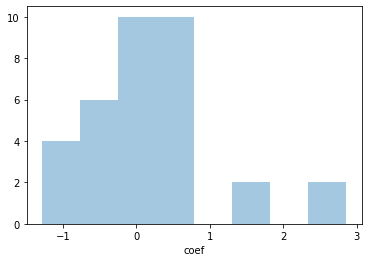

In [24]:
sns.distplot(coef.query('feature in @mech_mps')['coef'], kde=False)


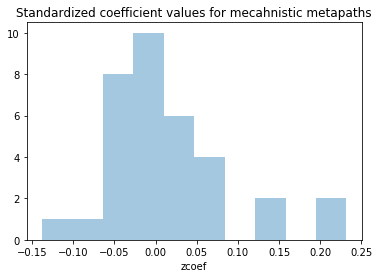

In [25]:
sns.distplot(coef.query('feature in @mech_mps')['zcoef'], kde=False)
plt.title("Standardized coefficient values for mecahnistic metapaths");

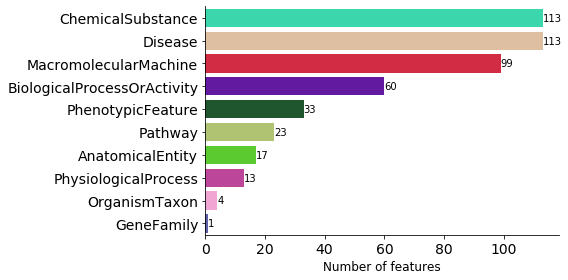

In [26]:
to_plot = found_mps.drop('feature', axis=1).sum()

default_pal = sns.color_palette()

this_colors = [node_color_map[l] for l in to_plot.index[::-1]]
sns.set_palette(this_colors)

fig = plt.figure(figsize=(8,4))
fig.set_tight_layout(True)

count_plot_h(to_plot)
plt.yticks(size=14)
plt.xlabel('Number of features', size=12)
plt.xticks(size=14)
sns.despine()
plt.savefig('coef_metanode.pdf');

In [27]:
# Were any features with directed edges selected?
coef[coef['feature'].str.contains('>', regex=False)]

,feature,coef,zcoef
24,CafBPprGr>GawD,0.975383,0.040488
177,CaG<rGr>GtD,-0.924024,-0.062563


## Examine moldel results

In [28]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

len(res)

85126262

In [29]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:87690,DOID:0060224,0,0.998078,"N-(2,6-dimethylphenyl)-2-\{4-[2-hydroxy-3-(2-m...",atrial fibrillation
1,CHEBI:27300,DOID:10609,1,0.997832,vitamin D,rickets


In [30]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [31]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [32]:
def get_path_info(compound, disease, n_jobs=30):
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [33]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [34]:
nodes.loc[nodes[nodes['name'].isnull()].index, 'name'] = nodes.loc[nodes[nodes['name'].isnull()].index, 'id']

### Look for Imatinib

In [35]:
find_nodes_by_name('matinib', n_type='ChemicalSubstance')

,id,name,label,xrefs,source
218281,IKEY:ZSASDYCFROUKTJ-UHFFFAOYSA-N,Flumatinib mesylate,ChemicalSubstance,IKEY:ZSASDYCFROUKTJ-UHFFFAOYSA-N|UNII:95Y8L63N...,integrity
231754,IKEY:BJCJYEYYYGBROF-UHFFFAOYSA-N,flumatinib,ChemicalSubstance,44methylpiperazin1ylmethyln6methyl54pyridin3yl...,NaN
233101,IKEY:COWBUPJEEDYWKD-UHFFFAOYSA-N,capmatinib dihydrochloride monohydrate,ChemicalSubstance,2fluoronmethyl47quinolin6ylmethylimidazo12b124...,NaN
233858,IKEY:ZTNPHABKLIJXTL-UHFFFAOYSA-N,capmatinib dihydrochloride,ChemicalSubstance,2fluoronmethyl47quinolin6ylmethylimidazo12b124...,NaN
245425,CHEBI:31690,imatinib methanesulfonate,ChemicalSubstance,CHEBI:31690|CHEBI:45783|IKEY:KTUFNOKKBVMGRW-UH...,gvk|informa|integrity


### Look for Asthma

In [36]:
find_nodes_by_name('sthma', n_type='Disease')

,id,name,label,xrefs,source
32304,DOID:0040040,hexamethylene diisocyanate allergic asthma,Disease,DOID:0040040,NaN
32305,DOID:0040041,isocyanates allergic asthma,Disease,DOID:0040041|MONDO:0025556,NaN
32306,DOID:0040042,"diphenylmethane-4,4'-diisocyanate allergic asthma",Disease,DOID:0040042,NaN
32307,DOID:0040043,toluene meta-diisocyanate allergic asthma,Disease,DOID:0040043,NaN
32308,DOID:0040044,methyl isocyanate allergic asthma,Disease,DOID:0040044,NaN
32309,DOID:0040045,nickel allergic asthma,Disease,DOID:0040045,NaN
32311,DOID:0040047,trimellitic anhydride allergic asthma,Disease,DOID:0040047,NaN
32312,DOID:0040048,phthalic anhydride allergic asthma,Disease,DOID:0040048,NaN
32313,DOID:0040049,maleic anhydride allergic asthma,Disease,DOID:0040049,NaN
32314,DOID:0040050,tetrachlorophthalic anhydride allergic asthma,Disease,DOID:0040050,NaN


In [37]:
imat = 'CHEBI:31690'
asth = 'DOID:2841'

In [38]:
imat_asth_res = res.query('chemicalsubstance_id == @imat and disease_id == @asth')
imat_asth_res

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
55645,CHEBI:31690,DOID:2841,0,0.354487,imatinib methanesulfonate,asthma


### Extract paths between Imatinib and Asthma

In [39]:
imat_asth = get_path_info(imat, asth, n_jobs=30)

100%|██████████| 113/113 [01:53<00:00,  1.01s/it]


In [40]:
imat_asth = imat_asth.sort_values('model_metric', ascending=False).reset_index(drop=True)
len(imat_asth)

6099512

Over 6 Million paths connecting these two concepts in our selected metapaths

In [41]:
imat_asth.head(10)

,metapath,metric,node_ids,nodes,model_metric,std_metric
0,CinGmPpsD,0.000038,"[CHEBI:31690, NCBIGene:217, HP:0002099, DOID:2...","[imatinib methanesulfonate, ALDH2, Asthma, ast...",0.360501,0.023380
1,CafBPawD,0.000069,"[CHEBI:31690, GO:0014827, DOID:2841]","[imatinib methanesulfonate, intestine smooth m...",0.350961,0.019404
2,CaBPawD,0.000047,"[CHEBI:31690, GO:0006006, DOID:2841]","[imatinib methanesulfonate, glucose metabolic ...",0.299133,0.014997
3,CinBPawD,0.000033,"[CHEBI:31690, GO:0014827, DOID:2841]","[imatinib methanesulfonate, intestine smooth m...",0.190192,0.008645
4,CafBPprGr>GawD,0.000005,"[CHEBI:31690, GO:1903409, RNAC:URS000059273E_9...","[imatinib methanesulfonate, reactive oxygen sp...",0.188799,0.006471
5,CinBPawD,0.000033,"[CHEBI:31690, GO:0070640, DOID:2841]","[imatinib methanesulfonate, vitamin D3 metabol...",0.185629,0.008320
6,CaGmD,0.000876,"[CHEBI:31690, NCBIGene:5515, DOID:2841]","[imatinib methanesulfonate, PPP2CA, asthma]",0.175465,0.007859
7,CaGmPpsD,0.000135,"[CHEBI:31690, NCBIGene:5515, HP:0002099, DOID:...","[imatinib methanesulfonate, PPP2CA, Asthma, as...",0.148022,0.011757
8,CaBPawD,0.000022,"[CHEBI:31690, GO:0043306, DOID:2841]","[imatinib methanesulfonate, positive regulatio...",0.142311,0.004696
9,CinBPawD,0.000023,"[CHEBI:31690, GO:0043306, DOID:2841]","[imatinib methanesulfonate, positive regulatio...",0.131965,0.004777


In [42]:
this_name = '14a_Model_results_analysis'
out_dir = load_dir.joinpath(this_name, 'out')
out_dir.mkdir(exist_ok=True, parents=True)

#imat_asth.to_csv(out_dir.joinpath('imat_asth_paths.csv'), index=False)

In [43]:
imat_asth.query('metapath == "CinGiBPawD"').head(10)

,metapath,metric,node_ids,nodes,model_metric,std_metric
299,CinGiBPawD,0.000004,"[CHEBI:31690, NCBIGene:3067, GO:0006548, DOID:...","[imatinib methanesulfonate, HDC, histidine cat...",0.007119,0.000098
403,CinGiBPawD,0.000003,"[CHEBI:31690, NCBIGene:3067, GO:0001694, DOID:...","[imatinib methanesulfonate, HDC, histamine bio...",0.005623,0.000062
740,CinGiBPawD,0.000002,"[CHEBI:31690, NCBIGene:217, GO:0006069, DOID:2...","[imatinib methanesulfonate, ALDH2, ethanol oxi...",0.002894,0.000017
792,CinGiBPawD,0.000002,"[CHEBI:31690, NCBIGene:217, GO:0006066, DOID:2...","[imatinib methanesulfonate, ALDH2, alcohol met...",0.002711,0.000015
913,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:780, GO:0014909, DOID:2...","[imatinib methanesulfonate, DDR1, smooth muscl...",0.002404,0.000012
933,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:217, GO:0006068, DOID:2...","[imatinib methanesulfonate, ALDH2, ethanol cat...",0.002365,0.000011
979,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",0.002249,0.000010
1072,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:25, GO:1904528, DOID:2841]","[imatinib methanesulfonate, ABL1, positive reg...",0.002055,0.000008
1124,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:6198, GO:0048633, DOID:...","[imatinib methanesulfonate, RPS6KB1, positive ...",0.001969,0.000008
1151,CinGiBPawD,0.000001,"[CHEBI:31690, NCBIGene:5175, GO:0090673, DOID:...","[imatinib methanesulfonate, PECAM1, endothelia...",0.001941,0.000008


### Find the KIT gene, known target for imatinib

In [44]:
find_nodes_by_name('KIT', n_type='MacromolecularMachine')

,id,name,label,xrefs,source
19596,REACT:R-CEL-1433473,"p-KIT (S741,746):PKC alpha",MacromolecularMachine,NaN,NaN
22865,REACT:R-HSA-1433419,PTPRU:KIT,MacromolecularMachine,NaN,NaN
22866,REACT:R-HSA-1433442,SOCS1:p-KIT complex,MacromolecularMachine,NaN,NaN
22867,REACT:R-HSA-1433473,"p-KIT (S741,746):PKC alpha",MacromolecularMachine,NaN,NaN
22868,REACT:R-HSA-1433493,JAK2:SFKS:p-KIT complex,MacromolecularMachine,NaN,NaN
22870,REACT:R-HSA-1433527,p-JAK2:SFKs:p-KIT complex:STATs,MacromolecularMachine,NaN,NaN
22871,REACT:R-HSA-1433530,p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN
22872,REACT:R-HSA-1433545,GAB2:GRB2:p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN
22873,REACT:R-HSA-1433549,GRB2:p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN
22874,REACT:R-HSA-1433552,p-JAK2:SFKs:p-KIT complex,MacromolecularMachine,NaN,NaN


In [45]:
ckit = 'NCBIGene:3815'

In [46]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [47]:
tgt_imat_asth = query_target(imat_asth, ckit)
len(tgt_imat_asth)

42407

In [48]:
tgt_imat_asth.head(10)

,metapath,metric,node_ids,nodes,model_metric,std_metric
301,CinGiBPnrGmD,1.422837e-06,"[CHEBI:31690, NCBIGene:3815, GO:0032762, NCBIG...","[imatinib methanesulfonate, KIT, mast cell cyt...",0.007081,0.000131
304,CaGmPmGtD,5.549343e-06,"[CHEBI:31690, NCBIGene:3815, HP:0030357, NCBIG...","[imatinib methanesulfonate, KIT, Small cell lu...",0.007031,0.000171
704,CinGprBPprGawD,5.593193e-07,"[CHEBI:31690, NCBIGene:3815, GO:0014065, NCBIG...","[imatinib methanesulfonate, KIT, phosphatidyli...",0.003032,0.000014
764,CaGiBPawD,1.679653e-06,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",0.002800,0.000018
816,CaGawPmGawD,2.519781e-07,"[CHEBI:31690, NCBIGene:3815, HP:0008069, NCBIG...","[imatinib methanesulfonate, KIT, Neoplasm of t...",0.002642,0.000014
943,CinGmPmGmD,9.835785e-07,"[CHEBI:31690, NCBIGene:3815, HP:0100723, NCBIG...","[imatinib methanesulfonate, KIT, Gastrointesti...",0.002327,0.000006
979,CinGiBPawD,1.246130e-06,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",0.002249,0.000010
1344,CaGawPmGawD,1.591937e-07,"[CHEBI:31690, NCBIGene:3815, HP:0006753, NCBIG...","[imatinib methanesulfonate, KIT, Neoplasm of t...",0.001669,0.000006
1346,CaGawPmGawD,1.591431e-07,"[CHEBI:31690, NCBIGene:3815, HP:0008069, NCBIG...","[imatinib methanesulfonate, KIT, Neoplasm of t...",0.001668,0.000006
1471,CaGawPmGawD,1.478940e-07,"[CHEBI:31690, NCBIGene:3815, HP:0006753, NCBIG...","[imatinib methanesulfonate, KIT, Neoplasm of t...",0.001550,0.000005


In [49]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [50]:
id_to_label = nodes.set_index('id')['label'].to_dict()

In [51]:
from data_tools import combine_nodes_and_edges

In [52]:
c = combine_nodes_and_edges(nodes, edges)

In [53]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6'}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()

In [54]:
import graph_plots as gp

In [55]:
def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, node_names=None, proba=proba, n_paths=len(list_of_paths));

#### Treatments for Asthma

In [56]:
imat_subset_res = res.query('disease_id == @asth').reset_index(drop=True)
len(imat_subset_res)

12449

In [57]:
imat_subset_res.query('chemicalsubstance_id == @imat')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
235,CHEBI:31690,DOID:2841,0,0.354487,imatinib methanesulfonate,asthma


In [58]:
# Imatinibs percentile
1 - ((235+1) / 12449)

0.981042654028436

#### Potential indications for Imatinib

In [59]:
asth_subset_res = res.query('chemicalsubstance_id == @imat').reset_index(drop=True)
len(asth_subset_res)

6838

In [60]:
asth_subset_res.query('disease_id == @asth')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
95,CHEBI:31690,DOID:2841,0,0.354487,imatinib methanesulfonate,asthma


In [61]:
# Asthma's percentile
1 - ((96+1) / 6838)

0.9858145656624744

In [62]:
res.query('chemicalsubstance_id == @imat and disease_id == @asth')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
55645,CHEBI:31690,DOID:2841,0,0.354487,imatinib methanesulfonate,asthma


In [63]:
##  Overall percentile
1 - ((55645+1) / len(res))

0.9993463121874188

In [64]:
'{:,}'.format(len(res))

'85,126,262'

## Draw some explainations

In [65]:
def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))


    
    if type(poi_idx) == list:
        ec = []
        for idx in poi_idx:
            poi = path_df.loc[idx, 'node_ids']
            ec.append(gp.highlight_path_of_interest(list_of_paths, poi))
        
        # Take the edges from the first highlighted poi
        edge_color_map = ec[0]
        for ecm in ec[1:]:
            for k, v in ecm.items():
                # Any other highlihted paths get marked
                # seaborn 1 is highlight color.
                if v == sns.color_palette().as_hex()[1]:
                    edge_color_map[k] = v
        
    elif poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    else:
        path_of_interest = []
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    
    

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map, min_dist=3)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, node_names=None, proba=proba, n_paths=10, xscale=17);

In [66]:
sns.set_palette(default_pal)

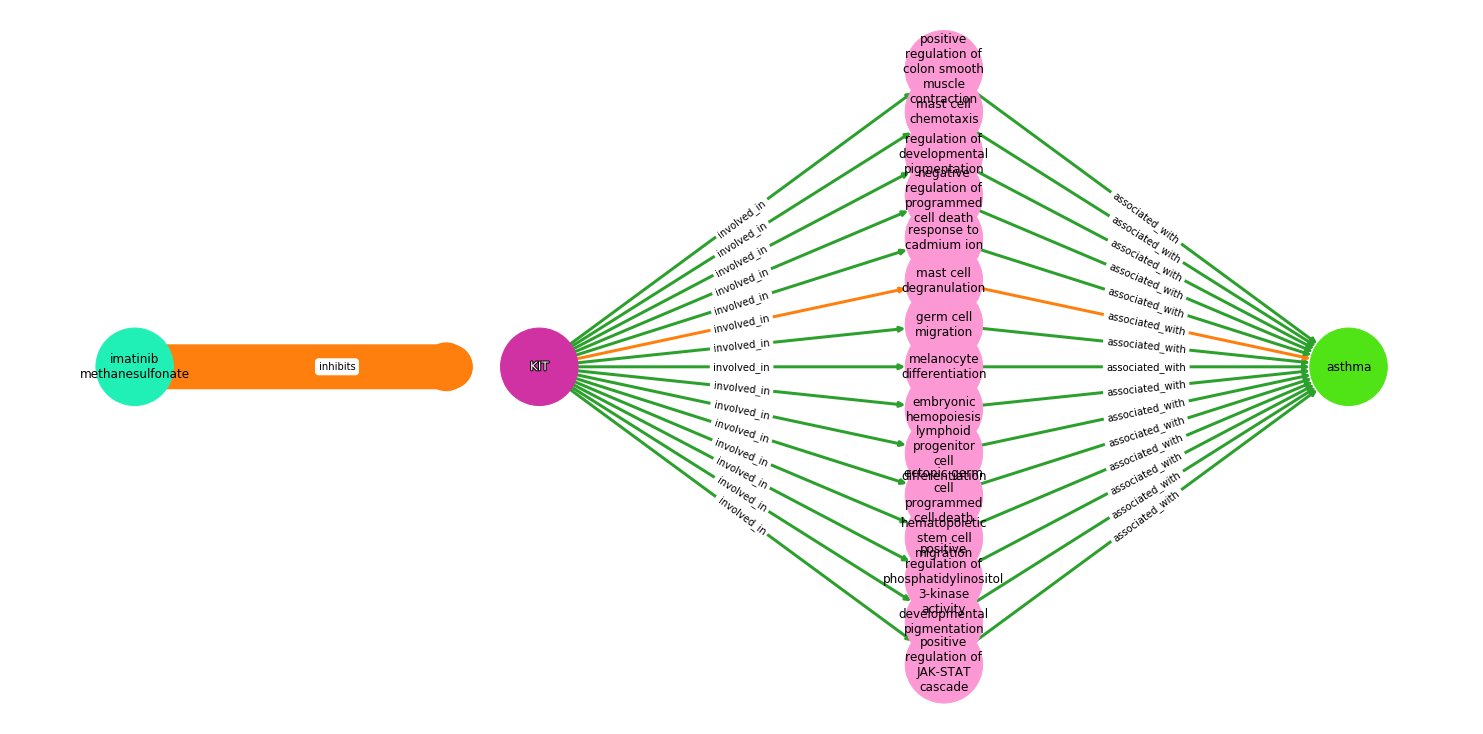

In [67]:
draw_top_paths(tgt_imat_asth.query('metapath == "CinGiBPawD"'), 15, 'std_metric', poi_idx=9158)
plt.savefig('imat_asth_mp.pdf')

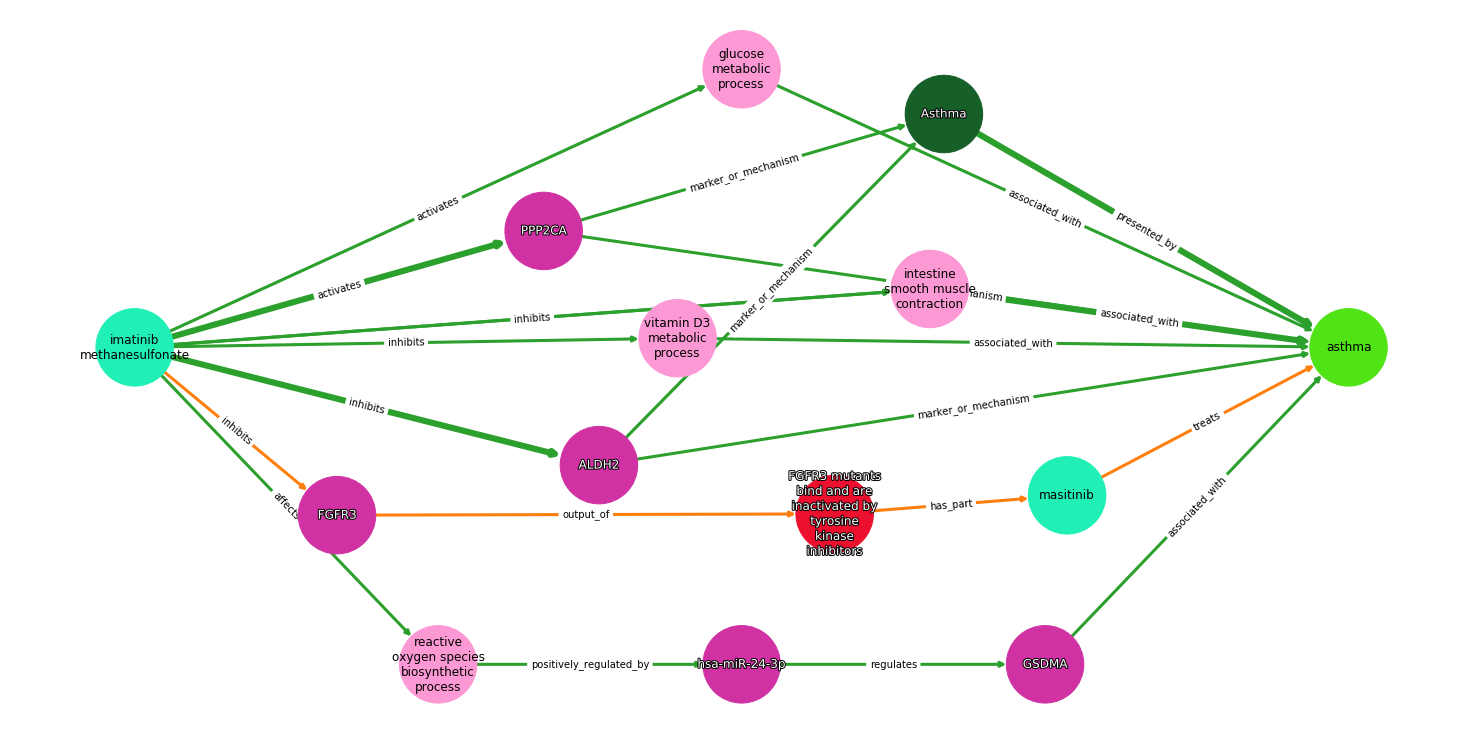

In [68]:
draw_top_paths(imat_asth, 10, 'std_metric', poi_idx=10)
plt.savefig('imat_asth_top10.pdf')

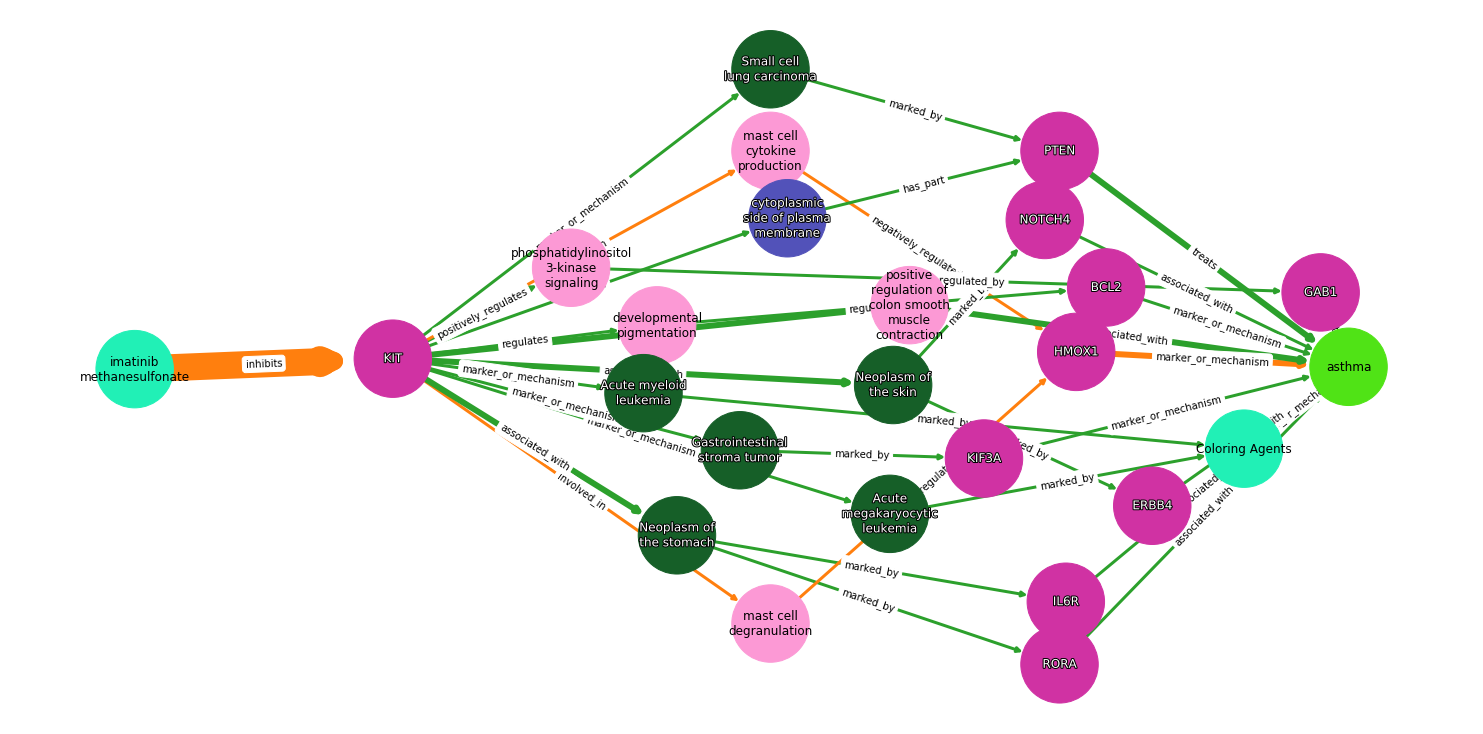

In [69]:
draw_top_paths(tgt_imat_asth, 15, 'std_metric', poi_idx=[1783,301])
plt.savefig('imat_asth_tgt.pdf')

In [70]:
c.query('start_name == "HMOX1" and end_name == "asthma"')[['type', 'source', 'dsrc_type', 'pmids']]

,type,source,dsrc_type,pmids
6528186,marker_or_mechanism_GmD,CTD,computed,18048809


In [71]:
mast_bp = ["mast cell degranulation", "mast cell cytokine production"]
c.query('start_name == "HMOX1" and end_name in @mast_bp')[['type', 'source', 'dsrc_type', 'comp_type']]

,type,source,dsrc_type,comp_type
3215168,negatively_regulates_GnrBP,Gene Ontology|WikiData,computed,punning
3215171,negatively_regulates_GnrBP,Gene Ontology|WikiData,computed,punning


In [72]:
c.query('start_name == "PTEN" and end_name == "asthma"')[['type', 'source', 'dsrc_type', 'pmids']]

,type,source,dsrc_type,pmids
6543585,treats_GtD,CTD,computed,17982072
